In [1]:
import dill
from main.manipulation import Manipulation
from main.data_processing import evaluate_profile, get_social_welfare_of_alternative
import pandas as pd
import numpy as np
from main.manipulation_utils import get_children_generation_options, check_transitivity, one_cost_children_generation, useful_change
from IPython.display import display
from copy import copy
from matplotlib import pyplot as plt
import seaborn as sns
import os

import seaborn as sns

In [2]:
def calculate_qualities_of_winners(input_data, df_result, k, method):
    """
    input_data: list of profiles
    df_result: processed dataframe with the results
    """
    num_alt = len(input_data[0][0])
    alph_order = {}
    for i in range(num_alt):
        alph_order[i] = i
        
    winners = df_result['result'].apply(lambda d: d[max(d.keys())][0] if d else None).values
    same_winner_times = 0
    qualities = []
    for i in range(len(winners)):
        if not pd.isnull(winners[i]):
            true_win = evaluate_profile(input_data[i], k, method, alph_order)[0]
            if true_win == winners[i]:
                same_winner_times+=1
            qualities.append(get_social_welfare_of_alternative(input_data[i], winners[i])-get_social_welfare_of_alternative(input_data[i], true_win))
    return qualities, same_winner_times

def get_qualities_of_winners(completeness, d_type, num_vot, num_alt, method, k, qualities_of_winners, input_data, dft):
    if (completeness, d_type, num_vot, num_alt, method, k) not in qualities_of_winners.keys():
        qualities, same_winner_times =calculate_qualities_of_winners(input_data[(num_vot, num_alt, d_type)], dft, k, method)
        qualities_of_winners[(completeness, d_type, num_vot, num_alt, method, k)]=(qualities, same_winner_times)
        with open('data/results/qualities_of_winners.pkl', 'wb') as f:
            dill.dump(qualities_of_winners, f)
    else:
        qualities, same_winner_times=qualities_of_winners[(completeness, d_type, num_vot, num_alt, method, k)]
    return qualities, same_winner_times

# data load and set-up

In [3]:
with open('data/results/total_result.pkl', 'rb') as f:
    total_result = dill.load(f)

### calculate quality of winners

In [4]:
with open('data/our_data_complete.pkl', 'rb') as f:
    input_data_complete = dill.load(f)
with open('data/our_data_incomplete.pkl', 'rb') as f:
    input_data_incomplete = dill.load(f)

In [5]:
data_df = pd.DataFrame(total_result).T
data_df.columns = ['convergence', 'result']

In [6]:
if os.path.isfile('data/results/qualities_of_winners.pkl'):
    with open('data/results/qualities_of_winners.pkl', 'rb') as f:
        qualities_of_winners = dill.load(f)
else:
    qualities_of_winners = {}

In [7]:
inds = []
convergence_rounds_all = {}
qualities_all = {}
same_winner_times_all = {}

for completeness in [True, False]:
    for num_alt in [3, 4, 5]:
        for d_type in ["2urn", "ic"]:
            for num_vot in [10, 20, 50]:
                for method in ['approval', 'veto']:
                    for k in [1, num_alt-1]: # [1, num_alt-1]
                        try:
                            dft = data_df.loc[(num_alt, num_vot, d_type, slice(None), k, method, 0, True, True, True, completeness)]
                            convergence_rounds = dft['result'].apply(lambda d: max(d.keys())+1 if d else 0)
                            input_data = {True: input_data_complete, False: input_data_incomplete}[completeness]
                            
                            qualities, same_winner_times= get_qualities_of_winners(completeness, d_type, num_vot, num_alt, method, k, qualities_of_winners, input_data, dft)

                            inds.append((num_alt, num_vot, d_type, completeness, method, k))
                            idx = inds[-1]
                            convergence_rounds_all[idx]=convergence_rounds
                            qualities_all[idx]=pd.Series(qualities)
                            same_winner_times_all[idx]=same_winner_times

                            print(f'k: {k}, {method}, num_alt: {num_alt}, num_vot: {num_vot}, d_type: {d_type}: percent of converged {dft["convergence"].max()*100}%, convergence rounds: mean={convergence_rounds.mean()}, max={convergence_rounds.max()}, std={convergence_rounds.std():.2f}, mean_quality: {np.mean(qualities):.2f}, times with no winner change: {same_winner_times}')
                        except KeyError:
                            pass

k: 1, approval, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.325, max=10, std=1.04, mean_quality: 0.26, times with no winner change: 8
k: 2, approval, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.615, max=7, std=1.24, mean_quality: 0.94, times with no winner change: 20
k: 1, veto, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=1.59, max=29, std=3.38, mean_quality: 2.07, times with no winner change: 31
k: 2, veto, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.255, max=3, std=0.67, mean_quality: 0.39, times with no winner change: 8
k: 1, approval, num_alt: 3, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.27, max=5, std=0.85, mean_quality: 1.91, times with no winner change: 11
k: 2, approval, num_alt: 3, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence r

k: 1, veto, num_alt: 4, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=65.25, max=647, std=106.71, mean_quality: 5.48, times with no winner change: 21
k: 3, veto, num_alt: 4, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=4.62, max=24, std=8.22, mean_quality: 5.04, times with no winner change: 26
k: 1, approval, num_alt: 5, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.35, max=7, std=0.97, mean_quality: 0.19, times with no winner change: 15
k: 4, approval, num_alt: 5, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=3.375, max=24, std=3.59, mean_quality: 8.10, times with no winner change: 55
k: 1, veto, num_alt: 5, num_vot: 10, d_type: 2urn: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0


<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.295, max=4, std=0.79, mean_quality: 1.35, times with no winner change: 14
k: 1, approval, num_alt: 5, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.275, max=5, std=0.97, mean_quality: -4.59, times with no winner change: 8
k: 4, approval, num_alt: 5, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence rounds: mean=6.025, max=31, std=6.25, mean_quality: 16.85, times with no winner change: 50
k: 1, veto, num_alt: 5, num_vot: 20, d_type: 2urn: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0


<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.275, max=5, std=0.97, mean_quality: -4.59, times with no winner change: 8
k: 1, approval, num_alt: 5, num_vot: 50, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.89, max=18, std=2.91, mean_quality: 9.20, times with no winner change: 14
k: 4, approval, num_alt: 5, num_vot: 50, d_type: 2urn: percent of converged 100%, convergence rounds: mean=6.835, max=58, std=10.22, mean_quality: 49.75, times with no winner change: 22
k: 1, veto, num_alt: 5, num_vot: 50, d_type: 2urn: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0


<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 50, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.89, max=18, std=2.91, mean_quality: 9.20, times with no winner change: 14
k: 1, approval, num_alt: 5, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=1.965, max=38, std=3.59, mean_quality: 1.94, times with no winner change: 42
k: 4, approval, num_alt: 5, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=2.16, max=16, std=2.54, mean_quality: 1.04, times with no winner change: 51
k: 1, veto, num_alt: 5, num_vot: 10, d_type: ic: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0


<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=1.46, max=5, std=1.75, mean_quality: 2.15, times with no winner change: 43
k: 1, approval, num_alt: 5, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds: mean=3.05, max=14, std=3.87, mean_quality: 2.79, times with no winner change: 45
k: 4, approval, num_alt: 5, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds: mean=2.195, max=14, std=2.89, mean_quality: 0.60, times with no winner change: 41
k: 1, veto, num_alt: 5, num_vot: 20, d_type: ic: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0


<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds: mean=3.075, max=12, std=3.86, mean_quality: 2.86, times with no winner change: 42
k: 1, approval, num_alt: 5, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=5.945, max=29, std=9.85, mean_quality: 6.69, times with no winner change: 30
k: 4, approval, num_alt: 5, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=2.565, max=29, std=4.74, mean_quality: 0.83, times with no winner change: 27
k: 1, veto, num_alt: 5, num_vot: 50, d_type: ic: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0


<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=5.945, max=29, std=9.86, mean_quality: 4.73, times with no winner change: 30
k: 1, approval, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.09, max=3, std=0.38, mean_quality: 1.23, times with no winner change: 2
k: 2, approval, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.915, max=7, std=1.42, mean_quality: 3.08, times with no winner change: 27
k: 1, veto, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.295, max=7, std=1.06, mean_quality: 1.61, times with no winner change: 10
k: 2, veto, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.265, max=3, std=0.60, mean_quality: 3.03, times with no winner change: 9
k: 1, approval, num_alt: 3, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence rounds:

k: 3, approval, num_alt: 4, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=12.53, max=44, std=14.37, mean_quality: 1.60, times with no winner change: 33
k: 1, veto, num_alt: 4, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=6.645, max=93, std=14.89, mean_quality: 2.40, times with no winner change: 31
k: 3, veto, num_alt: 4, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=6.76, max=26, std=8.91, mean_quality: 4.65, times with no winner change: 45
k: 1, approval, num_alt: 5, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.185, max=4, std=0.49, mean_quality: 4.42, times with no winner change: 4
k: 4, approval, num_alt: 5, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=2.475, max=12, std=2.38, mean_quality: 8.56, times with no winner change: 31
k: 1, veto, num_alt: 5, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence round

<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.785, max=6, std=1.10, mean_quality: 11.04, times with no winner change: 27
k: 1, approval, num_alt: 5, num_vot: 50, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.22, max=5, std=0.86, mean_quality: 8.33, times with no winner change: 7
k: 4, approval, num_alt: 5, num_vot: 50, d_type: 2urn: percent of converged 100%, convergence rounds: mean=12.79, max=49, std=8.87, mean_quality: 37.29, times with no winner change: 47
k: 1, veto, num_alt: 5, num_vot: 50, d_type: 2urn: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0


<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 50, d_type: 2urn: percent of converged 100%, convergence rounds: mean=1.03, max=10, std=1.93, mean_quality: 27.62, times with no winner change: 31
k: 1, approval, num_alt: 5, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=0.55, max=7, std=1.11, mean_quality: 2.58, times with no winner change: 16
k: 4, approval, num_alt: 5, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=4.465, max=14, std=2.98, mean_quality: 3.54, times with no winner change: 43
k: 1, veto, num_alt: 5, num_vot: 10, d_type: ic: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0


<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=2.845, max=9, std=2.22, mean_quality: 3.05, times with no winner change: 66
k: 1, approval, num_alt: 5, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds: mean=0.88, max=11, std=1.59, mean_quality: 1.66, times with no winner change: 32
k: 4, approval, num_alt: 5, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds: mean=11.56, max=34, std=6.33, mean_quality: 3.81, times with no winner change: 52
k: 1, veto, num_alt: 5, num_vot: 20, d_type: ic: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0


<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds: mean=4.775, max=14, std=4.28, mean_quality: 4.46, times with no winner change: 59
k: 1, approval, num_alt: 5, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=1.535, max=13, std=2.87, mean_quality: 3.16, times with no winner change: 32
k: 4, approval, num_alt: 5, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=27.16, max=65, std=19.85, mean_quality: 2.97, times with no winner change: 46
k: 1, veto, num_alt: 5, num_vot: 50, d_type: ic: percent of converged nan%, convergence rounds: mean=nan, max=nan, std=nan, mean_quality: nan, times with no winner change: 0


<ipython-input-7-1ade27f20359>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 4, veto, num_alt: 5, num_vot: 50, d_type: ic: percent of converged 100%, convergence rounds: mean=8.93, max=28, std=9.86, mean_quality: 5.95, times with no winner change: 46


# Plots
to check:

1. number of rounds to convergence (putting an upper bound for cycles)

2. number of non-manipulable profiles

3. quality of winner in truthful vs. equilibrium profile. 
- Definition: input: one alternative `a` and one truthful profile. For every voter, look at her preference. The quality of the alternative a is #1s - #(-1s) in the row of `a`. Sum up the quality of a for all voters. This is the social welfare.

Calculate social welfare for truthful winner and convergence winner, and subtract latter from former.

4. number of times where the winner was the same as the truthful one
----------------------------------------------------


for plotting:

1. x: number of rounds ; y: percentage of profiles (in the 200) that have converged for this x
each plot includes: ic,2urn,complete,incomplete. Different plots for (n,m) 

2. x: indices (n, m, ic, 2urn, complete, incomplete) ; y: percentage of non-manipulable profiles

3. x: quality of winner; y: percentage of profiles (in the 200) that have that quality of winner
each plot includes: ic,2urn,complete,incomplete. Different plots for (n,m) 

4. x: indices (n, m, ic, 2urn, complete, incomplete) ; y: percentage of profiles with true winner

# one

In [30]:
df=pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']

In [31]:
df=df[df['result']!=0]
df=df[df['result']<50]

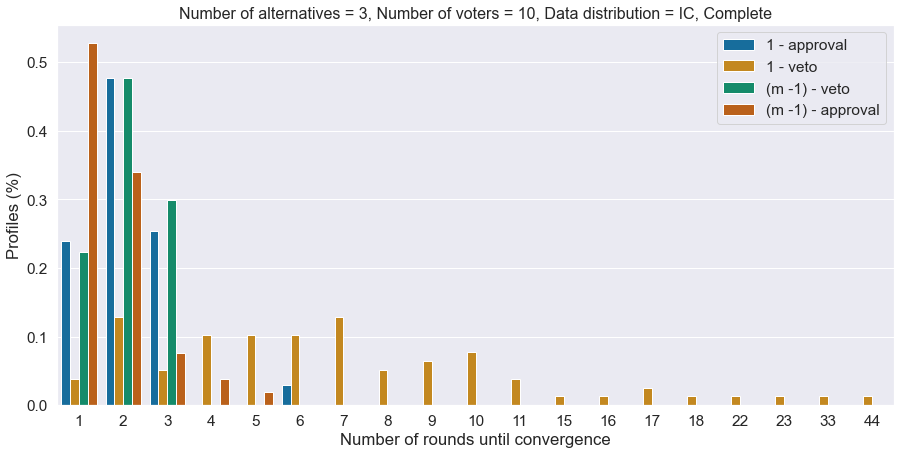

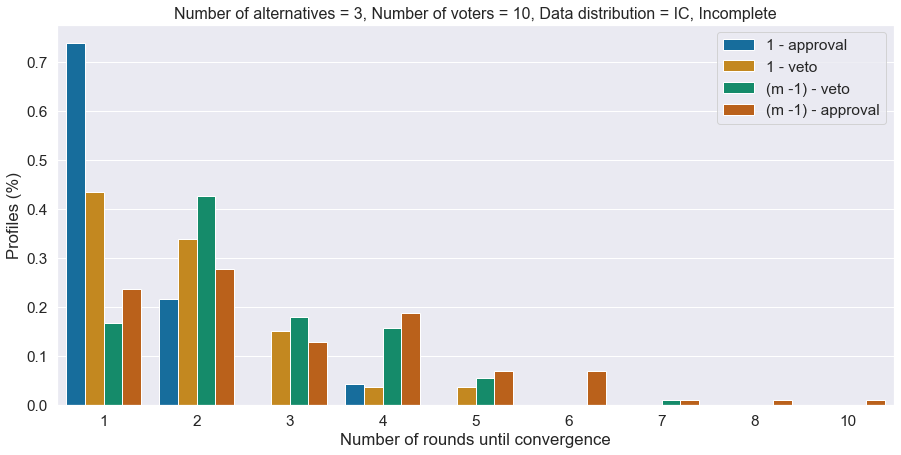

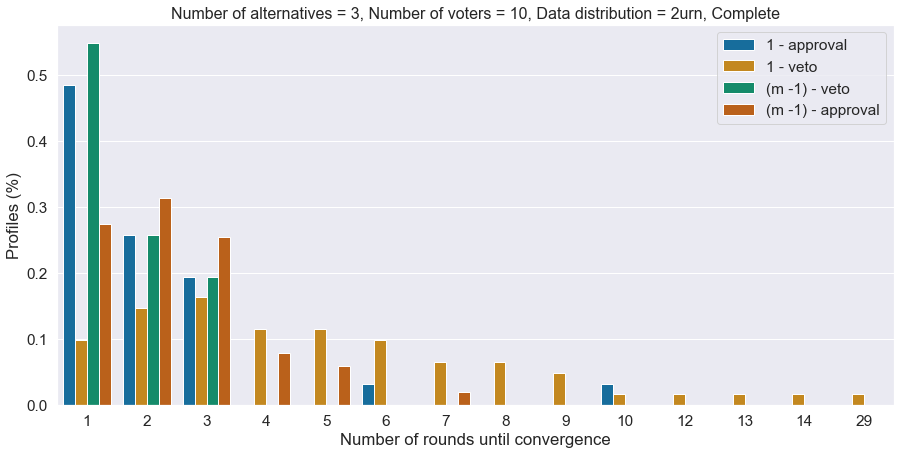

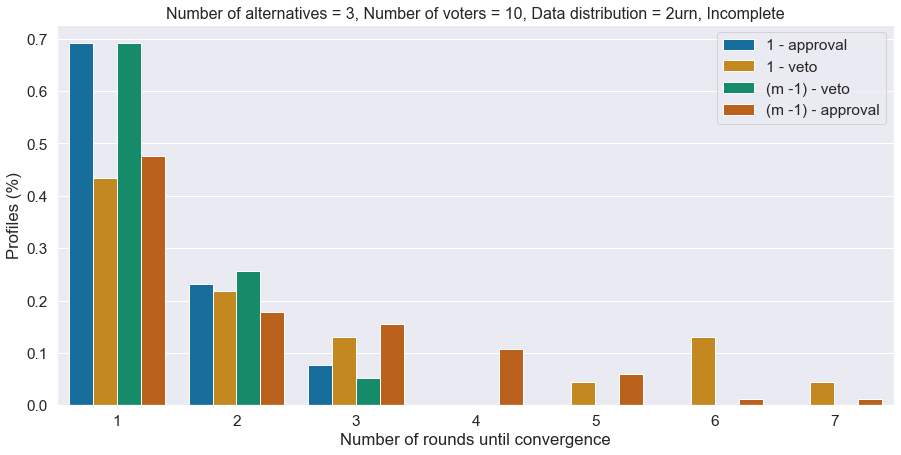

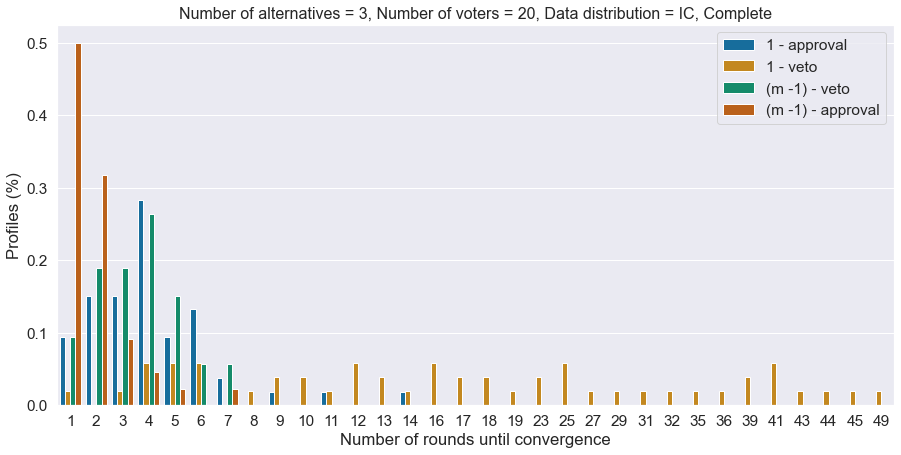

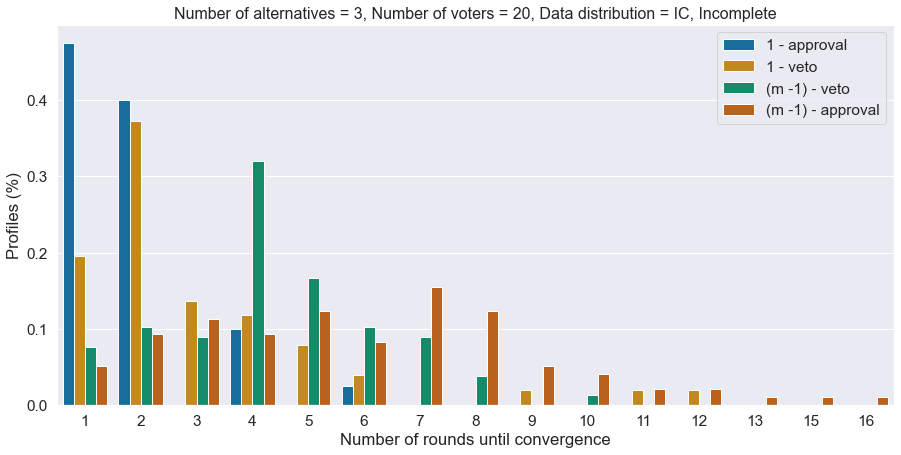

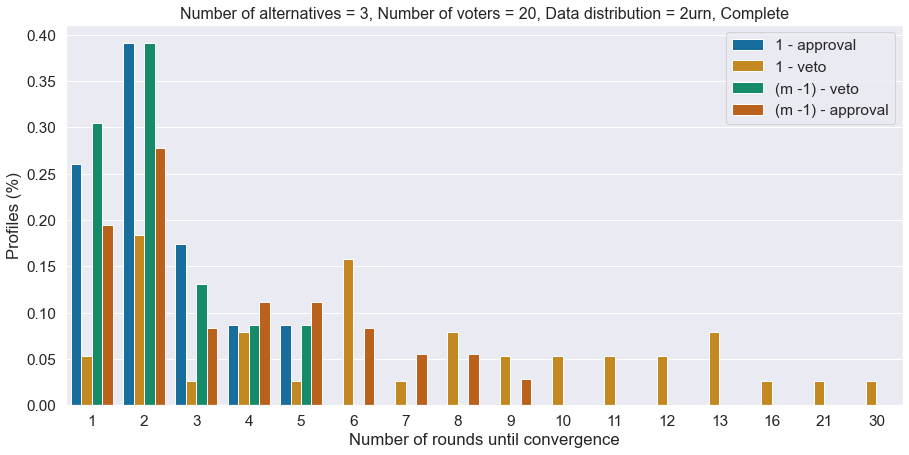

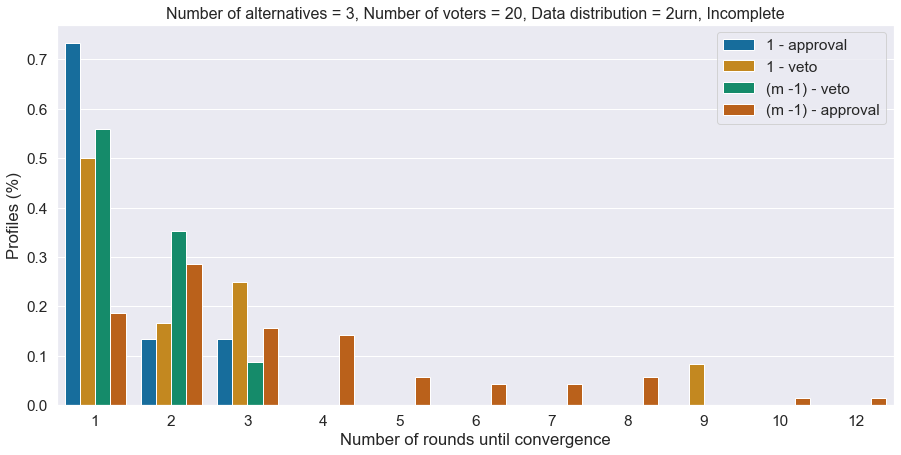

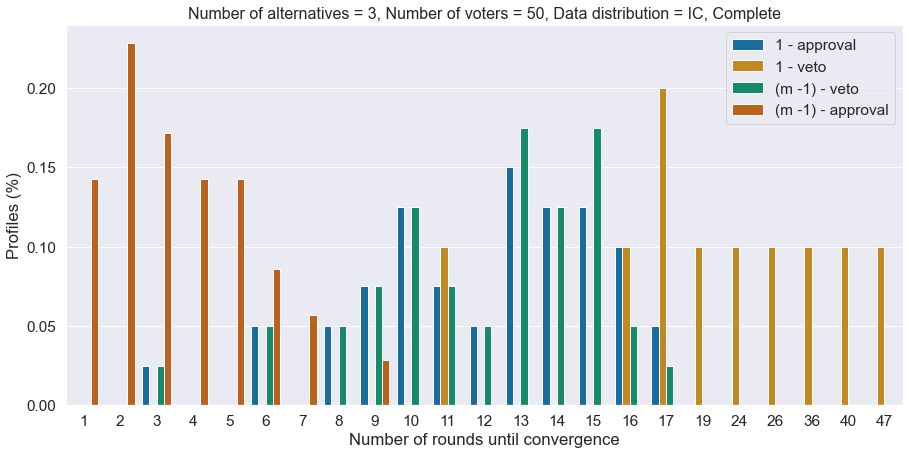

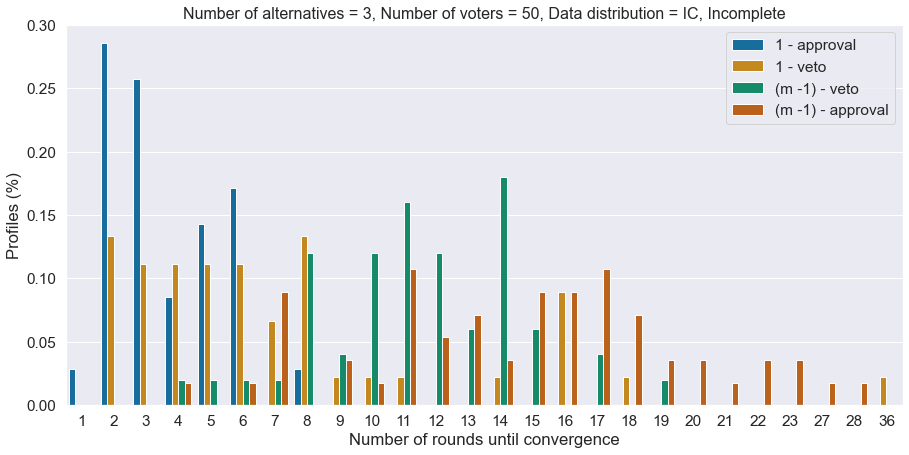

In [ ]:
for num_alt in [3, 4]:
    for num_vot in [10, 20, 50]:
            for data_type in ['ic', '2urn']:
                for completeness in [True, False]:
                    comp = {True: 'Complete', False: 'Incomplete'}[completeness]
                    dft = df.loc[(num_alt, num_vot, data_type, completeness, slice(None), slice(None))]
                    dft.reset_index(inplace=True)
                    dft=dft.groupby(['method', 'k']).apply(lambda df: df['result'].value_counts(normalize=True)).reset_index()
                    dft.rename(columns={'level_2': 'Number of rounds until convergence', 'result': 'Profiles (%)'}, inplace=True)
                    dft['k'] = dft['k'].apply(lambda x: '1' if x==1 else 'num_alt-1')
                    dft['Rule'] = dft.apply(lambda row: (f'{row["k"].replace("num_alt-1", "(m -1)")} - {row["method"]}'), axis=1) 
                    
                    sns.set(rc={'figure.figsize':(15,7)})
                    sns.set(font_scale=1.4)
                    sns.barplot(data=dft,
                                x ='Number of rounds until convergence',
                                y='Profiles (%)',
                                hue='Rule',
                                palette="colorblind",
                                hue_order=['1 - approval', '1 - veto', '(m -1) - veto', '(m -1) - approval'])
                    d_type2show = 'IC'if data_type=='ic' else data_type
                    plt.title(f'Number of alternatives = {num_alt}, Number of voters = {num_vot}, Data distribution = {d_type2show}, {comp}', fontsize=16)
                    plt.legend(loc='upper right')
                    plt.show()

# three

In [ ]:
df=pd.DataFrame(pd.concat(qualities_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']
df.rename(columns={0: 'qualities'}, inplace=True)

In [ ]:
for num_alt in [3, 4]:
    for num_vot in [10, 20, 50]:
        for data_type in ['ic', '2urn']:
            for completeness in [True, False]:
                comp = {True: 'Complete', False: 'Incomplete'}[completeness]
                dft = df.loc[(num_alt, num_vot, data_type, completeness, slice(None), slice(None))]
                dft.reset_index(inplace=True)
                dft=dft.groupby(['method', 'k']).apply(lambda df: df['qualities'].value_counts(normalize=True)).reset_index()
                dft.rename(columns={'level_2': 'Quality of iteration', 'qualities': 'Profiles (%)'}, inplace=True)
                
                dft['k'] = dft['k'].apply(lambda x: '1' if x==1 else 'num_alt-1')
                dft['Rule'] = dft.apply(lambda row: (f'{row["k"].replace("num_alt-1", "(m -1)")} - {row["method"]}'), axis=1)                            

                sns.set(rc={'figure.figsize':(15,7)})
                sns.set(font_scale=1.4)
                sns.barplot(data=dft,
                            x ='Quality of iteration',
                            y='Profiles (%)',
                            hue='Rule',
                            palette="colorblind",
                            hue_order=['1 - approval', '1 - veto', '(m -1) - veto', '(m -1) - approval'])
                
                d_type2show = 'IC'if data_type=='ic' else data_type
                plt.title(f'Number of alternatives = {num_alt}, Number of voters = {num_vot}, Data distribution = {d_type2show}, {comp}', fontsize=20)
                plt.legend(loc='upper right')
                plt.show()

# two

In [ ]:
df=pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)

In [ ]:
df=pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']
df.reset_index(inplace=True)
df['data_type']=df['data_type'].apply(lambda x: 'IC' if x=='ic' else x)

df['k'] = df['k'].apply(lambda x: '1' if x==1 else 'num_alt-1')

In [ ]:
for num_alt_to_show in [3, 4]:
    dft = df[df['num_alt']==num_alt_to_show] 

    dft=dft.groupby(['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']).apply(lambda x: (x['result']==0).sum()/len(x)).reset_index()
    dft.rename(columns={0: 'Non-manipulable profiles (%)', 'data_type': 'Data distribution'}, inplace=True)
    dft[f'\nNumber of alternatives = {num_alt_to_show}'] = dft.apply(lambda row: (row["num_vot"], {True: 'com', False:'incom'}[row["completeness"]]), axis=1)
    dft['Rule'] = dft.apply(lambda row: (f'{row["k"].replace("num_alt-1", "(m -1)")} - {row["method"]}'), axis=1)

    sns.set(font_scale=1.4)
    g=sns.catplot(x=f'\nNumber of alternatives = {num_alt_to_show}',
                y='Non-manipulable profiles (%)',
                hue="Rule",
                row='Data distribution',
                data=dft,
                kind="bar",
                order=[(10, 'incom'), (20, 'incom'), (50, 'incom'), (10, 'com'), (20, 'com'), (50, 'com')],
                hue_order=['1 - approval', '1 - veto', '(m -1) - veto', '(m -1) - approval'],
                height=4, aspect=2.5, palette='colorblind')

# four

In [16]:
df=pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']
df.reset_index(inplace=True)

df['same_winner_times'] = df.apply(lambda row: qualities_of_winners[(row['completeness'], row['data_type'], row['num_vot'], row['num_alt'], row['method'], row['k'])][1], axis=1)
df['k'] = df['k'].apply(lambda x: '1' if x==1 else 'num_alt-1')
df['data_type']=df['data_type'].apply(lambda x: 'IC' if x=='ic' else x)

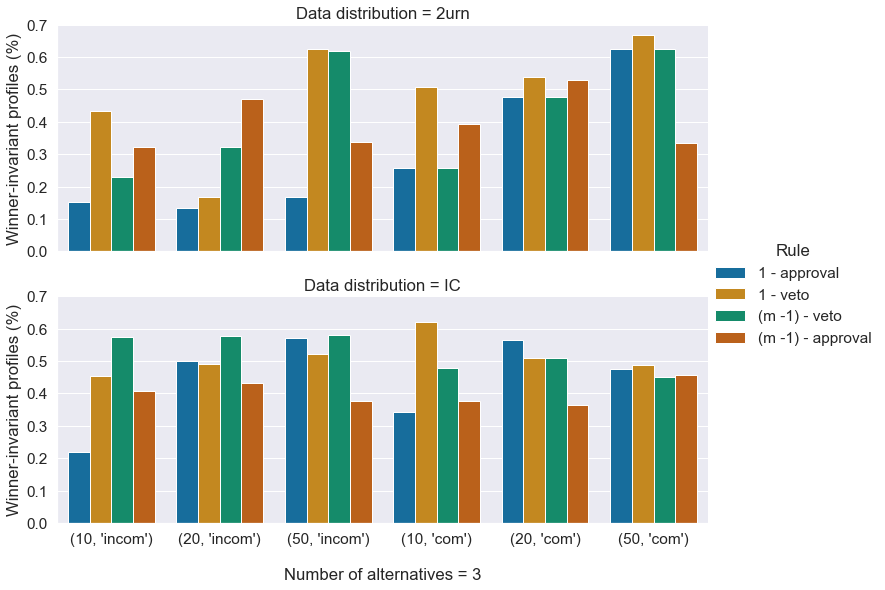

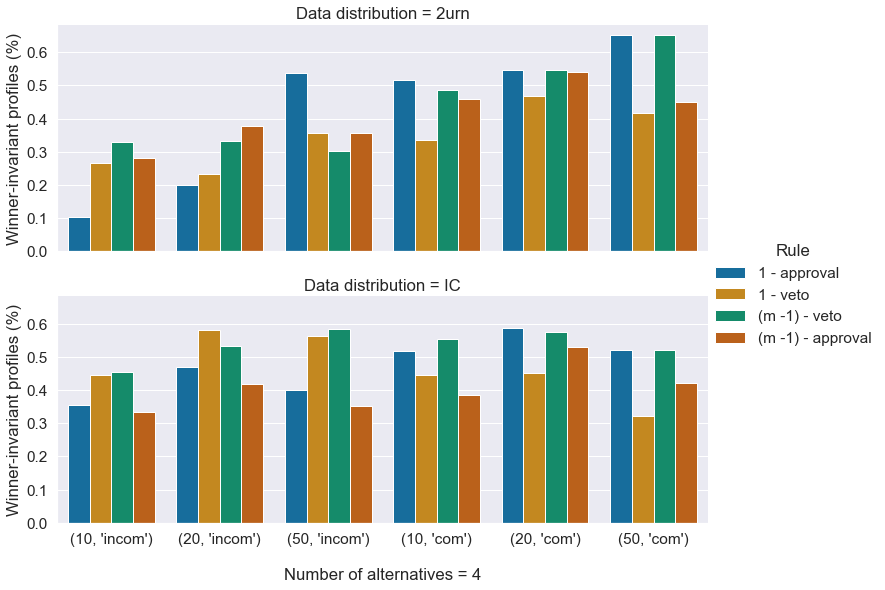

In [17]:
for num_alt_to_show in [3, 4]:
    dft = df[df['num_alt']==num_alt_to_show] 

    dft=dft.groupby(['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']).apply(lambda x: (x['same_winner_times'].mean())/(x['result']!=0).sum()).reset_index()

    dft.rename(columns={0: 'Winner-invariant profiles (%)'}, inplace=True)
    dft.rename(columns={'data_type': 'Data distribution'}, inplace=True)
    dft['Rule'] = dft.apply(lambda row: (f'{row["k"].replace("num_alt-1", "(m -1)")} - {row["method"]}'), axis=1)
    dft[f'\nNumber of alternatives = {num_alt_to_show}'] = dft.apply(lambda row: (row["num_vot"], {True: 'com', False:'incom'}[row["completeness"]]), axis=1)
    sns.set(font_scale=1.4)
    g=sns.catplot(x=f'\nNumber of alternatives = {num_alt_to_show}',
                y='Winner-invariant profiles (%)',
                hue="Rule",
                row='Data distribution',
                data=dft,
                kind="bar",
                order=[(10, 'incom'), (20, 'incom'), (50, 'incom'), (10, 'com'), (20, 'com'), (50, 'com')],
                hue_order=['1 - approval', '1 - veto', '(m -1) - veto', '(m -1) - approval'],
                height=4, aspect=2.5, palette='colorblind')